In [1]:
% v2approx -> v2_centerline. Load 'precalculation_GH_1_Nz' and allow different sensor input
close all;
clear;
rng(2); % rng('default')

G_solution = 4215; % INPUT
heat_flux_source = 852*1000; % INPUT [W/m2]
T_inlet_uniform = 300; % [K]

% G_solution = G_solution + sqrt(eps); % use if needed to prevent numerical issue from interpolation

## load data for 3d temperature profile

In [2]:
digit_thousands = floor(G_solution/1000);
digit_hundreds = floor((G_solution - digit_thousands*1000)/100);
digit_tens= floor((G_solution - digit_thousands*1000 - digit_hundreds*100)/10);
digit_ones= floor(G_solution - digit_thousands*1000 - digit_hundreds*100 - digit_tens*10);
inputname1      = ['./divisions_A_matrix/divisions_A_' num2str(digit_thousands) '' num2str(digit_hundreds) '' num2str(digit_tens) '' num2str(digit_ones) '.mat'];
load(inputname1,'A_div_L_qbcs1');

% calculate 3d temperature profile
T_steady = A_div_L_qbcs1*heat_flux_source + T_inlet_uniform;

## number grid

In [3]:
N_x_1 = 300+1; % INPUT total number of liquid grid points (including both ends) in x-direction
N_z = 100+1; % INPUT number of grid points (including both ends: inlet and outlet) in z-direction
N_x_2 = 40+1; % INPUT for solid substrate (including both ends: interface and outer wall)
N_x_tot = N_x_1 + N_x_2 - 1;
N_y = 19; % INPUT number of grid points in width direction

## INPUT sensor index (size: number sensor\*3)

In [4]:
% sensor_user_input = zeros(N_z-1,3); sensor_user_input(:,1) = 2:N_z; sensor_user_input(:,2) = N_x_1; sensor_user_input(:,3) = 1; % sensors all grid
% sensor_user_input = zeros(N_z-38,3); sensor_user_input(:,1) = 19:N_z-20; sensor_user_input(:,2) = N_x_1; sensor_user_input(:,3) = 1; % sensors all exp
sensor_user_input = [44,N_x_1,1; 72,N_x_1,1]; % 2 sensors
% sensor_user_input = [44,N_x_1,1; 52,N_x_1,1; 72,N_x_1,1]; % 2 sensors

## Phi: sensor index within the grid

In [5]:
sensor_index_z = sensor_user_input(:,1);
sensor_index_x = sensor_user_input(:,2);
sensor_index_y = sensor_user_input(:,3);
number_sensor = length(sensor_index_z);
sensor_index = sensor_index_z + (sensor_index_x-1)*N_z + (sensor_index_y-1)*N_z*N_x_tot; %

Phi_location_sensor = sparse(number_sensor, N_x_tot*N_z*N_y); % within
Phi_location_sensor_z = zeros(number_sensor, N_z);
for ids=1:size(sensor_index, 1)
    Phi_location_sensor(ids, sensor_index(ids)) = 1;
    Phi_location_sensor_z(ids, sensor_index_z(ids)) = 1;
end

## load interpolation matrix

In [6]:
inputname2 = 'table_divisions_A_matrix_centerline.mat';
load(inputname2,'sensor_user_input','table_GH','table_GH_Prt','table_GH_vt');

% convert table (all centerline) into table (sensor chosen)
table_GH = table_GH(: , [0, sensor_index_z']+1); % first index for G, remaining index for selected sensor
table_GH_Prt = table_GH_Prt(: , [0, sensor_index_z']+1);
table_GH_vt = table_GH_vt(: , [0, sensor_index_z']+1);

## construct linear Bayes inverse problem:
## Yobs = H\*theta + noise

Yobs accounts for temperature (including inlet T)


In [7]:
Yobs = Phi_location_sensor*T_steady - T_inlet_uniform; % n_sensor*1

n_parameter = 2; % number of unknowns
noise_magnitude_temperature = 0.1; % ************* INPUT [Kelvin] can use reduced std for time-averaged temperature meas.
cov_noise_temperature = noise_magnitude_temperature*noise_magnitude_temperature*eye(number_sensor);
% cov 0.04 = std 0.2 vs cov 0.2 = std 0.4472 required more burn-in length

## repeat chain for statistics

In [8]:
number_chain = 5;
iteration_RWM = 20000;

## repeat chain for statistics

In [9]:
x_history_RWM_save = zeros(n_parameter,iteration_RWM, number_chain);
prior_ratio_save = zeros(iteration_RWM, number_chain);
likelihood_ratio_save = zeros(iteration_RWM, number_chain);
pi_ratio_save = zeros(iteration_RWM, number_chain);
accept_percent_RWM_save= zeros(number_chain,1);

mu_x_prior = zeros(n_parameter,1);
mu_x_prior = [heat_flux_source*1.0; G_solution*1.0]; % ************* INPUT
cov_x_prior = [(heat_flux_source/10).*(heat_flux_source/10), 0; 0 (G_solution/10).*(G_solution/10)]; % INPUT
cov_x_prior_inv = eye(n_parameter)/cov_x_prior;

## for modeling error

In [10]:
error_mag = 5; % INPUT (modeling uncertainty)
error_width = 5; % reference modeling error bound (+- 5 percent modeling uncertainty)
num_w = 11; % Define the number of grids (must be an odd number)

% Calculate the step size
step_w = 2*error_width / num_w;
% Generate the sequence of vectors
w_vector = linspace(-error_width + step_w/2, error_width - step_w/2, num_w);

% Method 1: Repeat each element length(grid_vector) times consecutively
w_vector_repeat_1 = repelem(w_vector, num_w); % 1*(num_w*num_w)
% Method 2: Repeat the entire vector length(grid_vector) times
w_vector_repeat_2 = repmat(w_vector, 1, num_w); % 1*(num_w*num_w)

fraction_Pr_turb = w_vector_repeat_1/error_width*(error_mag/error_width);
fraction_vt = w_vector_repeat_2/error_width*(error_mag/error_width);

term_bracket_prev = zeros(num_w*num_w, 1);
term_bracket_next = zeros(num_w*num_w, 1);
T_diff_prev = zeros(number_sensor, 1);
T_diff_next = zeros(number_sensor, 1);

dTcalc_prev_Pr_turb = zeros(number_sensor, num_w*num_w);
dTcalc_prev_vt = zeros(number_sensor, num_w*num_w);
dTcalc_next_Pr_turb = zeros(number_sensor, num_w*num_w);
dTcalc_next_vt = zeros(number_sensor, num_w*num_w);

for index_chain=1:number_chain

## random walk metropolis

In [11]:
x_prev = mu_x_prior*(1+2*rand())/2;
step_size_RWM = cov_x_prior*0.001; % input
x_history_RWM = zeros(n_parameter, iteration_RWM); % row: history of each variable, avoid non-physical G to begin with
accept_count_RWM = 0;

for index_RWM=1:iteration_RWM

    x_history_RWM(:,index_RWM) = x_prev;

    % propose new parameter
    x_next = x_prev + mvnrnd(zeros(n_parameter,1), step_size_RWM, 1)'; % mu, sigma, number of random vector

## prior
<pre>
   prior_prev = mvnpdf(x_prev, mu_x_prior, cov_x_prior); % X, mu, sigma
   prior_next = mvnpdf(x_next, mu_x_prior, cov_x_prior);
</pre>

## likelihood

model: x(1) go to Q, x(2) go to G


In [12]:
    G_prev = x_prev(2);
    G_next = x_next(2);

    H_prev = myLinearInterp(table_GH(:,1), table_GH(:,2:end), G_prev)'; % n_sensor*1
    H_next = myLinearInterp(table_GH(:,1), table_GH(:,2:end), G_next)'; % n_sensor*1
    H_prev_Prt110 = myLinearInterp(table_GH_Prt(:,1), table_GH_Prt(:,2:end), G_prev)'; % n_sensor*1
    H_next_Prt110 = myLinearInterp(table_GH_Prt(:,1), table_GH_Prt(:,2:end), G_next)'; % n_sensor*1
    H_prev_vt110 = myLinearInterp(table_GH_vt(:,1), table_GH_vt(:,2:end), G_prev)'; % n_sensor*1
    H_next_vt110 = myLinearInterp(table_GH_vt(:,1), table_GH_vt(:,2:end), G_next)'; % n_sensor*1

    Tcalc_prev = H_prev*x_prev(1);
    Tcalc_next = H_next*x_next(1);
    dTcalc_prev_Pr_turb = (H_prev_Prt110*x_prev(1) - Tcalc_prev)*fraction_Pr_turb;
    dTcalc_prev_vt = (H_prev_vt110*x_prev(1) - Tcalc_prev)*fraction_vt;
    dTcalc_next_Pr_turb = (H_next_Prt110*x_next(1) - Tcalc_next)*fraction_Pr_turb;
    dTcalc_next_vt = (H_next_vt110*x_next(1) - Tcalc_next)*fraction_vt;

## ratio

prior ratio prior\_ratio = exp(\-1/2\*((x\_next\-mu\_x\_prior)'\*cov\_x\_prior\_inv\*(x\_next\-mu\_x\_prior)\-(x\_prev\-mu\_x\_prior)'\*cov\_x\_prior\_inv\*(x\_prev\-mu\_x\_prior) ));


In [13]:
    prior_ratio = 1;

    % likelihood ratio without modeling error
    likelihood_ratio_next_prev = exp(-1/2/noise_magnitude_temperature^2*((H_next*x_next(1)-Yobs)'*(H_next*x_next(1)-Yobs)-(H_prev*x_prev(1)-Yobs)'*(H_prev*x_prev(1)-Yobs)));

    % initialization
    ratio_modeling_next_prev = 0;

    % Calculate the difference for all iw simultaneously
    T_diff_prev = Tcalc_prev - dTcalc_prev_Pr_turb - dTcalc_prev_vt - Yobs;
    T_diff_next = Tcalc_next - dTcalc_next_Pr_turb - dTcalc_next_vt - Yobs;

    % Calculate the squared norm differences for all iw
    term_bracket_prev = sum(T_diff_prev.^2, 1) - sum((Tcalc_prev - Yobs).^2);
    term_bracket_next = sum(T_diff_next.^2, 1) - sum((Tcalc_next - Yobs).^2);

    % term inside exponential
    term_bracket_prev = -1/2/noise_magnitude_temperature^2*term_bracket_prev;
    term_bracket_next = -1/2/noise_magnitude_temperature^2*term_bracket_next;
    log_sum_exp_term_bracket_prev = max(term_bracket_prev) + log(sum(exp(term_bracket_prev-max(term_bracket_prev))));
    log_sum_exp_term_bracket_next = max(term_bracket_next) + log(sum(exp(term_bracket_next-max(term_bracket_next))));
    ratio_modeling_next_prev = exp(log_sum_exp_term_bracket_next - log_sum_exp_term_bracket_prev);

    % resulting likelihood ratio
    likelihood_ratio = likelihood_ratio_next_prev*ratio_modeling_next_prev;
    pi_ratio = likelihood_ratio*prior_ratio;

    likelihood_ratio_next_prev_save(index_RWM, index_chain) = likelihood_ratio_next_prev;
%     ratio_modeling_prev_save(index_RWM, index_chain) = ratio_modeling_prev;
%     ratio_modeling_next_save(index_RWM, index_chain) = ratio_modeling_next;
    prior_ratio_save(index_RWM, index_chain) = prior_ratio;
    likelihood_ratio_save(index_RWM, index_chain) = likelihood_ratio;
    pi_ratio_save(index_RWM, index_chain) = pi_ratio;
    ratio_modeling_next_prev_save(index_RWM, index_chain) = ratio_modeling_next_prev;

%     pi_prev = prior_prev*likelihood_prev;
%     pi_next = prior_next*likelihood_next;
%     pi_ratio = exp(log(pi_next)-log(pi_prev));
    accept_ratio = min(1,pi_ratio); % between 0 and 1

## update

In [14]:
    update_rand = rand(); % between 0 and 1

    if accept_ratio >= update_rand
        x_prev = x_next; % accept
        accept_count_RWM = accept_count_RWM + 1;
    end % do nothing otherwise: keep the same Z_prev

end
accept_percent_RWM = accept_count_RWM/iteration_RWM;
accept_percent_RWM_save(index_chain) = accept_percent_RWM;

x_history_RWM_save(:,:,index_chain) = x_history_RWM; % save result
end

## choose burn\-in step and compute auto\-correlation


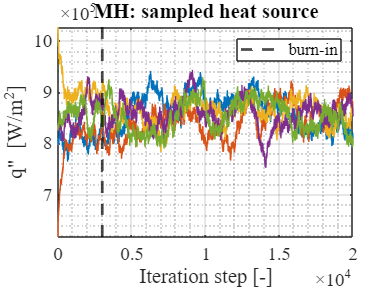


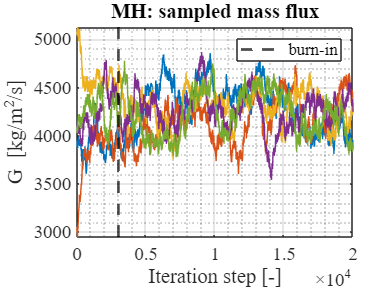

In [15]:
burn_in = 3000; % input: remove upto the input index of adaptive
x_history_selected = x_history_RWM_save(:,(burn_in+1):end,:);

for index_plot=1:2
    figure(index_plot); % trace plot RWM, chain 1, plot index 2
    set(gcf, 'WindowState', 'maximized');

    % subplot(1,2,index_plot)
    x_max_plot = max(x_history_RWM_save(index_plot,:,:),[],'all');
    x_min_plot = min(x_history_RWM_save(index_plot,:,:),[],'all');
    for index_chain=1:number_chain
    plot(1:iteration_RWM, x_history_RWM_save(index_plot,:,index_chain),'handlevisibility','off')
    hold on
    end
    xline(burn_in,'k--','linewidth',2,'displayname',' burn-in')
    grid on
    grid minor
    xlabel('Iteration step [-]')
    if index_plot == 1
        ylabel('q" [W/m^2]')
        title('MH: sampled heat source')
        ylim([x_min_plot x_max_plot])
    elseif index_plot == 2
        ylabel('G [kg/m^2/s]')
        title('MH: sampled mass flux')
        ylim([x_min_plot x_max_plot])
    end
    set(gca,'FontSize',14,'fontname','times')
    legend('show','location','northeast')
end

## result from posterior distribution

In [16]:
x_history_selected_reshaped = reshape(x_history_selected, n_parameter, []); % merge all selected result

mu_x_posterior = mean(x_history_selected_reshaped, 2);
cov_x_posterior = cov(x_history_selected_reshaped'); % 2*2

## visualize result: prior ellipsoid and posterior histories

ellipse of confidence bound ([https://www.xarg.org/2018/04/how\-to\-plot\-a\-covariance\-error\-ellipse/](https://www.xarg.org/2018/04/how-to-plot-a-covariance-error-ellipse/))


In [17]:
confidence_interval = 0.95; % INPUT confidence interval
scale_ellipsoid = -2*log(1 - confidence_interval); % equal to chi2inv(p, 2)
[eig_vector, eig_diag] = eig(cov_x_prior * scale_ellipsoid); % eig_vector gives axis of ellipsoid
[eig_diag, order] = sort(diag(eig_diag), 'descend');
eig_diag = diag(eig_diag);
eig_vector = eig_vector(:, order);
plot_angles = linspace(0, 2*pi);
ellipse_radius_prior = sqrt(eig_diag); % major and minor radius in diagonal entry
plot_ellipse = ellipse_radius_prior*[cos(plot_angles(:))'; sin(plot_angles(:))'];


plot bivariate distribution: input data is an Nx2 matrix containing two variables


In [18]:
bivar_Q = x_history_selected_reshaped(1,:)';
bivar_G = x_history_selected_reshaped(2,:)';
% std from covariance

% Create a grid of points over the range of Q and G
Q_vals = linspace(700*1000, 1000*1000, 500);
G_vals = linspace(3000, 5200, 500);
[Q_grid, G_grid] = meshgrid(Q_vals, G_vals);

pdf_total = zeros(size(Q_grid)); % Initialize PDF matrix
% Calculate the bivariate Gaussian PDF at each grid point
for i = 1:length(Q_vals)
    for j = 1:length(G_vals)
        x = [Q_grid(i, j), G_grid(i, j)]';
        pdf_total(i, j) = mvnpdf(x, mu_x_posterior, cov_x_posterior);  % Multivariate normal PDF
    end
end

% analytical pdf expression for G and Q
sigma_Q = sqrt(cov_x_posterior(1, 1));  % Standard deviation of Q [kW/m2]
sigma_G = sqrt(cov_x_posterior(2, 2));  % Standard deviation of G [kg/m2/s]

% Mean values of G and Q (you should already have these from your data)
mu_Q = mu_x_posterior(1);  % Mean of Q [W/m2]
mu_G = mu_x_posterior(2);  % Mean of G

% Define the range for G and Q based on the sample data
x_Q = linspace(min(bivar_Q), max(bivar_Q), 100);  % 100 points for Q
x_G = linspace(min(bivar_G), max(bivar_G), 100);  % 100 points for G

% Compute the PDF of G and Q using the Gaussian formula
pdf_Q = (1 / sqrt(2 * pi * sigma_Q^2)) * exp(-(x_Q - mu_Q).^2 / (2 * sigma_Q^2));
pdf_G = (1 / sqrt(2 * pi * sigma_G^2)) * exp(-(x_G - mu_G).^2 / (2 * sigma_G^2));

## plot result


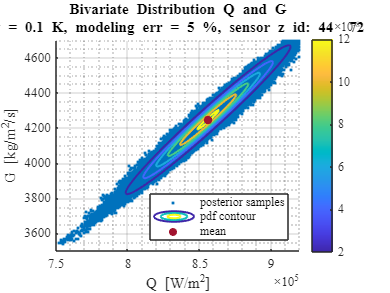

In [19]:
figure;
set(gcf, 'WindowState', 'maximized');
% subplot(2,2,[1,3]); % plot the pdf contour
% scatter(mu_x_prior(1), mu_x_prior(2), 40, 'filled','displayname',' prior mean','MarkerFaceColor','#0072BD')
% hold on
% plot(mu_x_prior(1) + plot_ellipse(1,:)/2 , mu_x_prior(2) + plot_ellipse(2,:)/2,'--','displayname',' 1 sigma','color','#0072BD')
% hold on
% plot(mu_x_prior(1) + plot_ellipse(1,:) , mu_x_prior(2) + plot_ellipse(2,:),'--','displayname',' 2 sigma','color','#0072BD')
% hold on
scatter(bivar_Q, bivar_G, '.','displayname',' posterior samples','MarkerEdgeColor','#0072BD');
hold on
contour(Q_grid, G_grid, pdf_total, 'LineWidth', 1.5,'displayname',' pdf contour');
hold on
scatter(mu_x_posterior(1), mu_x_posterior(2), 40, 'filled','displayname',' mean','MarkerFaceColor','#A2142F')

colormap('parula'); % Change 'parula' to any colormap you prefer
h1 = colorbar();  % Create a horizontal colorbar below the plot
xlabel('Q [W/m^2]');
ylabel('G [kg/m^2/s]');
legend('show','location','southeast')
title({
    'Bivariate Distribution Q and G', ...
    ['\sigma = ', num2str(noise_magnitude_temperature), ' K, modeling err = ', num2str(error_mag), ' %, sensor z id: ', num2str(sensor_index_z')]
});
set(gca,'FontSize',10,'fontname','times')
grid on;
grid minor;
% xlow = 650*1000; xhigh = 1050*1000;
% ylow = 3200; yhigh = 5200;
xlow = 750*1000; xhigh = 920*1000;
ylow = 3500; yhigh = 4700;
xlim([xlow xhigh])
ylim([ylow yhigh])


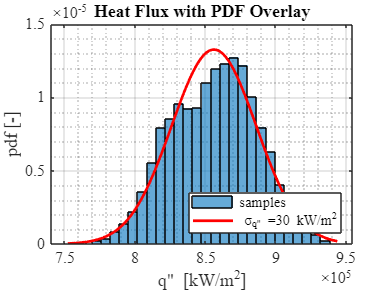

In [20]:

% Q (heat flux) histogram and PDF
figure;
set(gcf, 'WindowState', 'maximized');
histogram(bivar_Q, 30, 'Normalization', 'pdf','displayname',' samples');
hold on
plot(x_Q, pdf_Q, 'r-', 'LineWidth', 2,'displayname', strcat(' σ_{q"} = ', num2str(sigma_Q/1000, '%.0f'),' kW/m^2'));
legend('show','location','southeast')
xlabel('q" [kW/m^2]');
ylabel('pdf [-]');
title('Heat Flux with PDF Overlay');
set(gca,'FontSize',12,'fontname','times')
grid on
grid minor


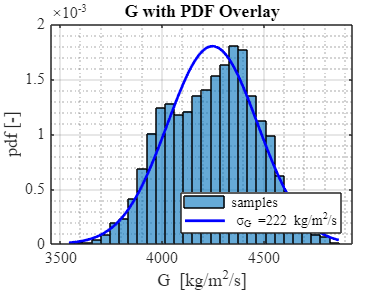

In [21]:

% G histogram and PDF
figure;
set(gcf, 'WindowState', 'maximized');
histogram(bivar_G, 30, 'Normalization', 'pdf','displayname',' samples');
hold on
plot(x_G, pdf_G, 'b-', 'LineWidth', 2,'displayname', strcat(' σ_{G} = ', num2str(sigma_G, '%.0f'),' kg/m^2/s'));
legend('show','location','southeast')
xlabel('G [kg/m^2/s]');
ylabel('pdf [-]');
title('G with PDF Overlay');
set(gca,'FontSize',12,'fontname','times')
grid on
grid minor